In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease-2024/Heart Cr -3.csv
/kaggle/input/heart-disease-2024/Combine.csv
/kaggle/input/heart-disease-2024/MainData.xlsx


wolta documentation is [here](https://wolta-docs.readthedocs.io/en/latest/)

In [2]:
!pip install wolta

BigD dataset loaded successfully!
[INFO] Detecting outliers...
[INFO] Outlier Detection Complete:
       Column Has_Outliers
0         sex           No
1         age           No
2        Smkr           No
3     oldpeak          Yes
4         fbs          Yes
5          cp           No
6     restecg           No
7       exang          Yes
8        chol          Yes
9    trestbps          Yes
10      diaBP          Yes
11        BMI          Yes
12  heartRate          Yes
13    glucose          Yes
target
0    3281
1     502
Name: count, dtype: int64


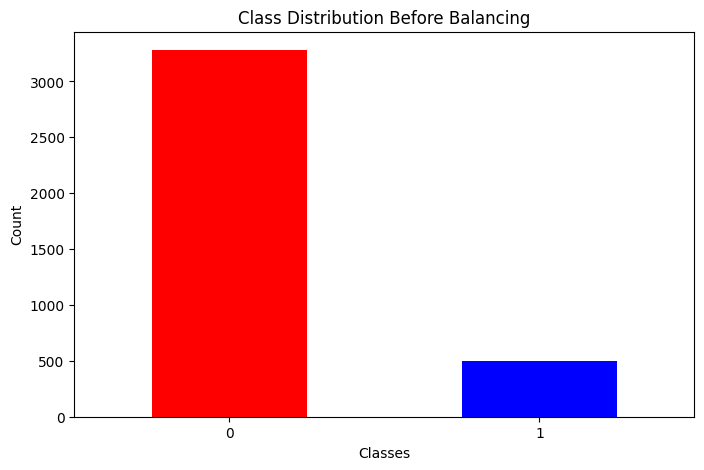

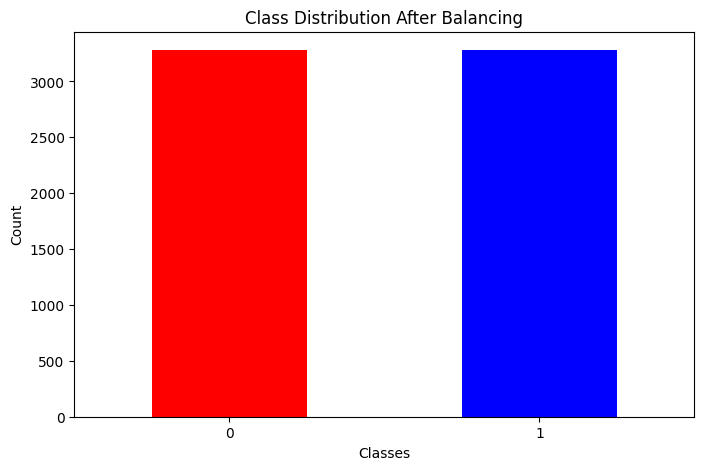

Data balanced using SMOTE.
target
0    3281
1    3281
Name: count, dtype: int64
Feature Importances:
                    Feature  Importance
1                       age    0.145709
0                       sex    0.133951
5                        cp    0.111854
9                  trestbps    0.082340
8                      chol    0.079623
10                    diaBP    0.065887
13                  glucose    0.064216
12                heartRate    0.063475
11                      BMI    0.060449
6                   restecg    0.055004
3                   oldpeak    0.047215
2                      Smkr    0.037687
15  glucose_category_Normal    0.028124
14     glucose_category_Low    0.019633
16    glucose_category_High    0.004832
4                       fbs    0.000000
7                     exang    0.000000


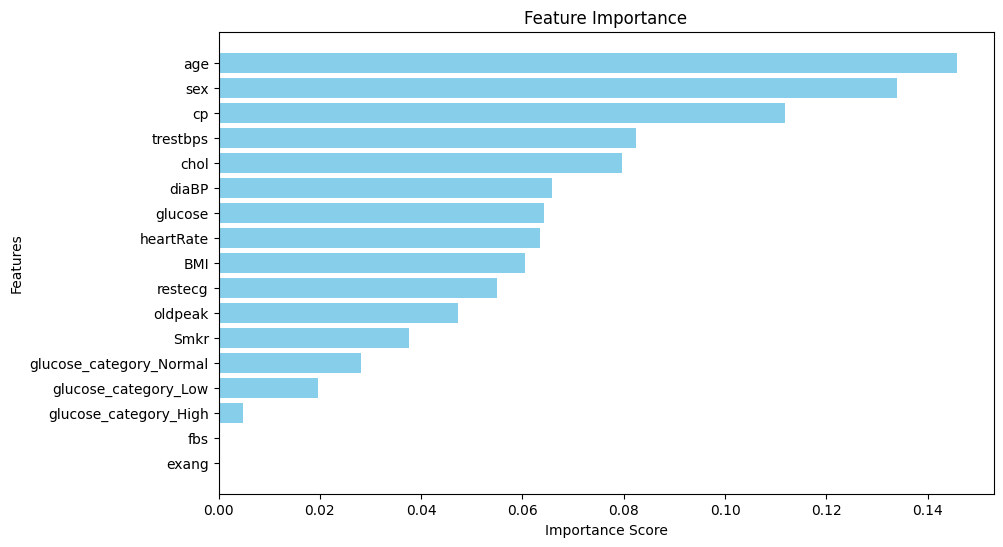


[INFO] Training CatBoost...

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       657
           1       0.98      0.86      0.92       656

    accuracy                           0.92      1313
   macro avg       0.93      0.92      0.92      1313
weighted avg       0.93      0.92      0.92      1313



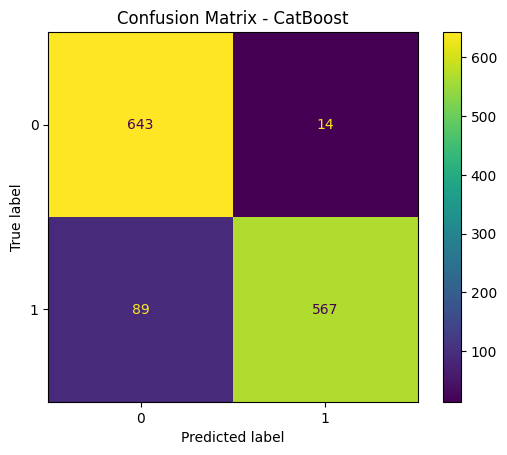

CatBoost Metrics:
  Accuracy: 92.16%
  Precision: 92.71%
  Recall: 92.16%
  F1-score: 92.13%

[INFO] Training LightGBM...
[LightGBM] [Info] Number of positive: 2625, number of negative: 2624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3615
[LightGBM] [Info] Number of data points in the train set: 5249, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500095 -> initscore=0.000381
[LightGBM] [Info] Start training from score 0.000381

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       657
           1       0.96      0.88      0.91       656

    accuracy                           0.92      1313
   macro avg       0.92      0.92      0.92      1313
weighted avg       0

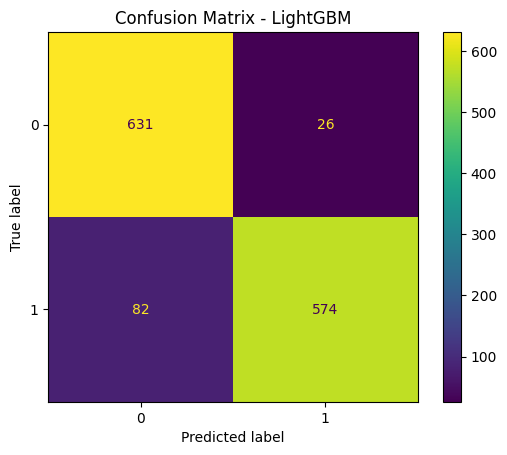

LightGBM Metrics:
  Accuracy: 91.77%
  Precision: 92.08%
  Recall: 91.77%
  F1-score: 91.76%

[INFO] Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       657
           1       0.96      0.90      0.93       656

    accuracy                           0.93      1313
   macro avg       0.94      0.93      0.93      1313
weighted avg       0.94      0.93      0.93      1313



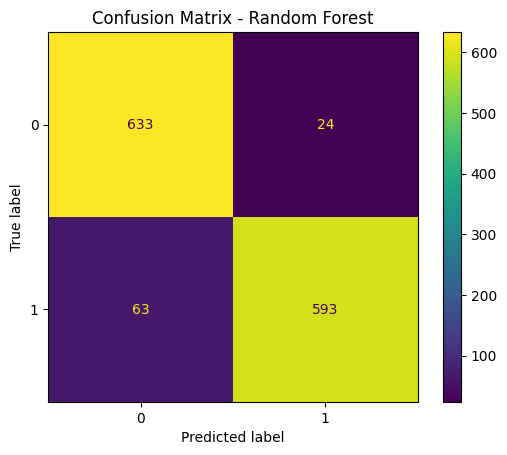

Random Forest Metrics:
  Accuracy: 93.37%
  Precision: 93.53%
  Recall: 93.37%
  F1-score: 93.37%

[INFO] Training Extra Trees...

Extra Trees Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       657
           1       0.97      0.94      0.95       656

    accuracy                           0.95      1313
   macro avg       0.95      0.95      0.95      1313
weighted avg       0.95      0.95      0.95      1313



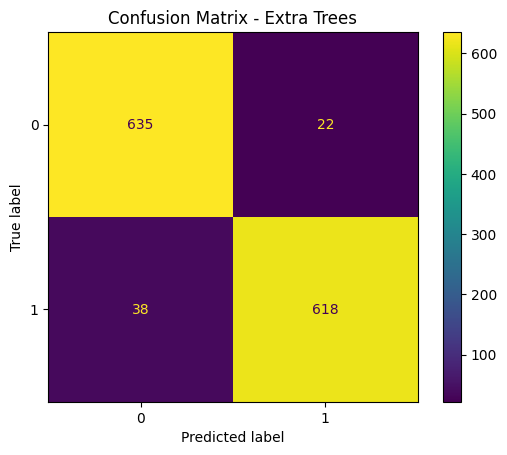

Extra Trees Metrics:
  Accuracy: 95.43%
  Precision: 95.46%
  Recall: 95.43%
  F1-score: 95.43%


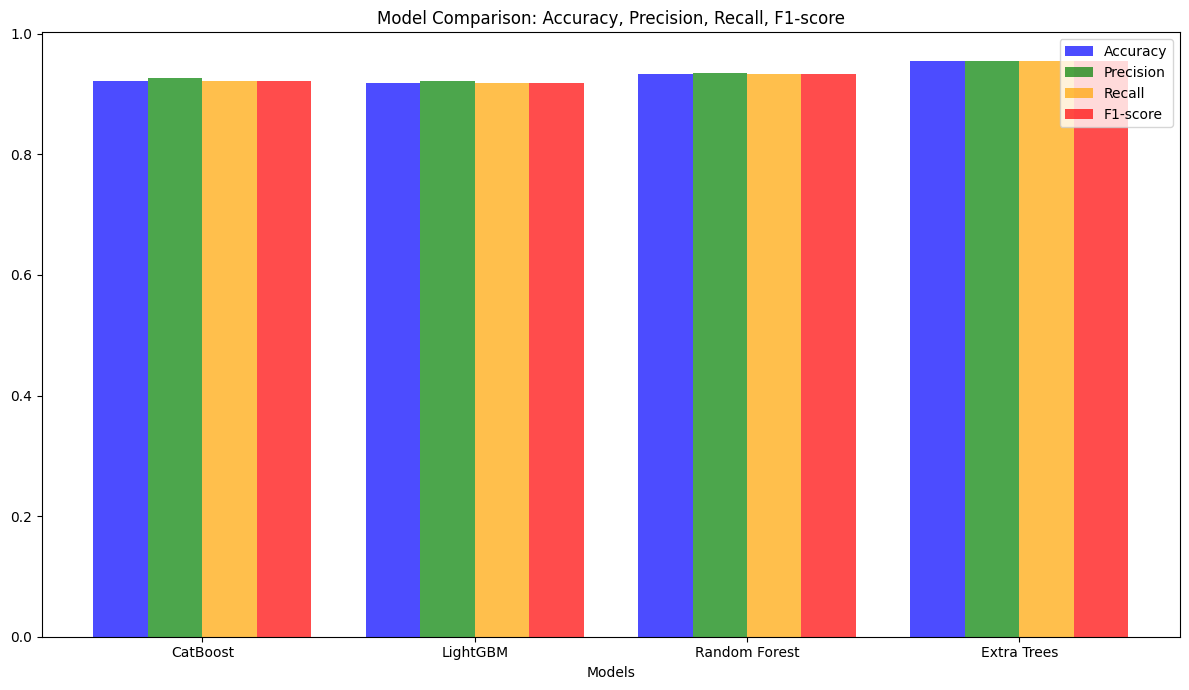

In [3]:

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from wolta.data_tools import expand_df


# Function to load datasets
def load_dataset(dataset_name):
    try:
        # df = pd.read_excel(file_path)
        df = pd.read_excel('/kaggle/input/heart-disease-2024/MainData.xlsx')

        print(f"{dataset_name} dataset loaded successfully!")
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")
        raise
    return df

# Function to preprocess data
def preprocess_data(df, target_column='target', balance_data=True):
    numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
    numerical_columns.remove(target_column)

    print("[INFO] Detecting outliers...")
    outlier_columns = {}
    for col in numerical_columns:
        mean = df[col].mean()
        std = df[col].std()
        outliers = ((df[col] < mean - 3 * std) | (df[col] > mean + 3 * std)).any()
        outlier_columns[col] = 'Yes' if outliers else 'No'
    outlier_df = pd.DataFrame(list(outlier_columns.items()), columns=['Column', 'Has_Outliers'])
    print("[INFO] Outlier Detection Complete:")
    print(outlier_df)

    # Remove outliers
    for col in numerical_columns:
        mean = df[col].mean()
        std = df[col].std()
        df = df[(df[col] >= mean - 3 * std) & (df[col] <= mean + 3 * std)]

    # print(df.value_counts())
    # Bin glucose levels into categories
    bins = [0, 80, 100, float('inf')]
    labels = ['Low', 'Normal', 'High']
    df['glucose_category'] = pd.cut(df['glucose'], bins=bins, labels=labels)

    # Apply One-Hot Encoding for glucose categories
    df = pd.get_dummies(df, columns=['glucose_category'], drop_first=False)
    print(df['target'].value_counts())

    plt.figure(figsize=(8, 5))
    df[target_column].value_counts().plot(kind='bar', color=['red', 'blue'])
    plt.title("Class Distribution Before Balancing")
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

    # Handle imbalanced classes

    df = expand_df(df, target_column, 'minority')
    y = df[target_column].values
    X = df.drop(columns=[target_column])

    feature_names = X.columns.tolist()

    # Optionally balance data using SMOTE
    if balance_data:
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)
        X = pd.DataFrame(X, columns=feature_names)

    # Visualize class distribution after balancing
    plt.figure(figsize=(8, 5))
    pd.Series(y).value_counts().plot(kind='bar', color=['red', 'blue'])
    plt.title("Class Distribution After Balancing")
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

    print("Data balanced using SMOTE.")
    print(df['target'].value_counts())

    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X, y)
    importance = rf.feature_importances_
    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    print("Feature Importances:")
    print(importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
    plt.gca().invert_yaxis()  # Reverse the order for better readability
    plt.title("Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()


    return X, y, feature_names

# Train-test split
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Train and evaluate models
def train_and_evaluate(X_train, y_train, X_test, y_test):
    models = {
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
        "LightGBM": LGBMClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
        "Extra Trees": ExtraTreesClassifier(random_state=42, n_estimators=100)
    }

    results = {}
    metrics = { "Accuracy": [], "Precision": [], "Recall": [], "F1-score": [] }
    model_names = list(models.keys())  # List of model names

    for name, model in models.items():
        print(f"\n[INFO] Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f"\n{name} Classification Report:")
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        # Extract metrics
        accuracy = report['accuracy']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1_score = report['weighted avg']['f1-score']

        print(f"{name} Metrics:")
        print(f"  Accuracy: {report['accuracy'] * 100:.2f}%")
        print(f"  Precision: {precision * 100:.2f}%")
        print(f"  Recall: {recall * 100:.2f}%")
        print(f"  F1-score: {f1_score * 100:.2f}%")

        # Store results
        results[name] = {
            "model": model,
            "classification_report": report,
            "confusion_matrix": cm
        }

        # Collect metrics for comparison
        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-score"].append(f1_score)

    return results, metrics, model_names

# Visualization function to compare models
def plot_comparison(metrics, model_names):
    x = np.arange(len(model_names))  # Model indices
    width = 0.2  # Bar width

    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot bars for each metric
    ax.bar(x - 1.5 * width, metrics["Accuracy"], width, label="Accuracy", color='blue', alpha=0.7)
    ax.bar(x - 0.5 * width, metrics["Precision"], width, label="Precision", color='green', alpha=0.7)
    ax.bar(x + 0.5 * width, metrics["Recall"], width, label="Recall", color='orange', alpha=0.7)
    ax.bar(x + 1.5 * width, metrics["F1-score"], width, label="F1-score", color='red', alpha=0.7)

    # Labeling the chart
    ax.set_xlabel('Models')
    ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1-score')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Main pipeline
def main():
    dataset_name = "BigD"
    df = load_dataset(dataset_name)

    X, y, feature_names = preprocess_data(df, target_column='target', balance_data=True)
    X_train, X_test, y_train, y_test = split_data(X.values, y)

    results, metrics, model_names = train_and_evaluate(X_train, y_train, X_test, y_test)

    # Plot comparisons
    plot_comparison(metrics, model_names)

    return results

if __name__ == "__main__":
    main()